# OpenStreetMap Data Wrangling and Case Study
***
***

## Project
The goal of this project was to clean fields of interest using Python and explore the OpenStreetMap data for a specific geographical area using SQL.

I cleaned all of the top 26 tag keys apart from 'name', which can only be cleaned manually, and four 'tiger' keys.  I also cleaned the fields that I found most interesting such as amenities, all phone tags, shops, delivery, cuisine, and cleaned all address fields except for addr:housename which can only be cleaned by verifying each individual value against some authority.

## Map Area
The data covers all of lower Manhattan (south of about 40th Street) and parts of Brooklyn including portions of DUMBO, Vinegar Hill, Navy Yard, and Williamsburg.  The [area](https://www.openstreetmap.org/#map=13/40.7269/-73.9929) is between 40.6976 and 40.7562 latitude and -74.0199 and -73.9661 longitude.  I chose this area, since I love the city and hope to live there someday.

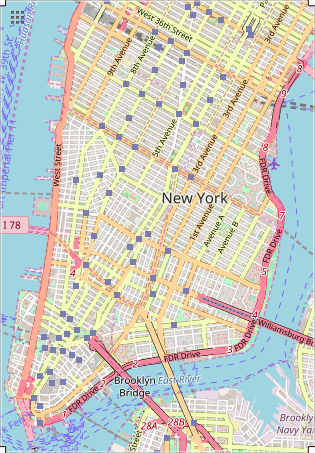

In [1]:
from IPython.display import Image
Image('map_area.png')

## Data Overview

### File Sizes
```
lower_manhattan.osm ..... 59.6 MB
osm.db .................. 59.3 MB
nodes.csv ............... 17.6 MB
nodes_tags.csv .......... 2.7 MB
ways.csv ................ 2.2 MB
ways_tags.csv ........... 6.2 MB
ways_nodes.cv ........... 7.4 MB
relations.csv ........... 58 KB
relations_tags.csv ...... 130 KB
relations_members.csv ... 1.8 MB
```

In [2]:
%load_ext sql
%sql sqlite:///osm.db
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch

There are three types of entities in the map: nodes, ways, and relations.  In addition, nodes have tags, ways have tags and nodes, and relations have members and tags.  Each of these are represented in a separate table.  The vast majority of the interesting data lies within the tags.

In [3]:
%%sql
SELECT name
FROM sqlite_master
WHERE type='table'
ORDER BY name;

Done.


name
Node
NodeTag
Relation
RelationMember
RelationTag
Way
WayNode
WayTag


### Number of nodes

In [4]:
%%sql
SELECT COUNT(*) AS Count
FROM Node

Done.


Count
196006


### Number of ways

In [5]:
%%sql
SELECT COUNT(*) AS Count
FROM Way

Done.


Count
35165


### Number of relations

In [6]:
%%sql
SELECT COUNT(*) AS Count
FROM Relation

Done.


Count
985


### Number of tags

In [7]:
%%sql
-- Will use this view for most of the queries
CREATE VIEW tags AS
SELECT * FROM NodeTag 
UNION ALL
SELECT * FROM WayTag
UNION ALL
SELECT * FROM RelationTag;

-- Number of tags
SELECT COUNT(*) AS Count
FROM tags;

(sqlite3.OperationalError) table tags already exists [SQL: '-- Will use this view for most of the queries\nCREATE VIEW tags AS\nSELECT * FROM NodeTag \nUNION ALL\nSELECT * FROM WayTag\nUNION ALL\nSELECT * FROM RelationTag;']


In [8]:
%%sql
-- Number of unique tags
SELECT COUNT (DISTINCT key) AS Count
FROM tags;

Done.


Count
644


In [9]:
%%sql
-- Most popular tags
SELECT key, COUNT(*) AS Count
FROM tags
GROUP BY key
ORDER BY Count DESC
LIMIT 25;

Done.


key,Count
height,26292
addr:street,25942
addr:housenumber,25930
addr:postcode,25322
building,19457
nycdoitt:bin,19092
name,11677
highway,8971
roof:shape,8425
building:colour,8351


### Users

In [10]:
%%sql
CREATE VIEW all_entities AS
SELECT id, user, uid, version, changeset, timestamp FROM Node 
UNION ALL
SELECT * FROM Way
UNION ALL
SELECT * FROM Relation;

-- Number of unique users
SELECT COUNT(DISTINCT user) AS Count
FROM all_entities
ORDER BY Count DESC;

(sqlite3.OperationalError) table all_entities already exists [SQL: 'CREATE VIEW all_entities AS\nSELECT id, user, uid, version, changeset, timestamp FROM Node \nUNION ALL\nSELECT * FROM Way\nUNION ALL\nSELECT * FROM Relation;']


In [11]:
%%sql
-- Top contributing users
SELECT user, COUNT(user) AS Count
FROM all_entities
GROUP BY user
ORDER BY Count DESC
LIMIT 10;

Done.


user,Count
lxbarth_nycbuildings,63936
Rub21_nycbuildings,61233
robgeb,45310
ALE!,9906
celosia_nycbuildings,3494
tre1994,2628
wambag,2346
zingbot_nycbuildings,2277
cityracks,1798
aaron_nycbuildings,1775


In [12]:
%%sql
-- The number of users that have only made one post
SELECT COUNT(*)
FROM (SELECT COUNT(user) AS Count
      FROM all_entities
      GROUP BY user
      HAVING COUNT=1
      ORDER BY Count DESC) counts

Done.


COUNT(*)
481


In [13]:
%%sql
-- The top 10 tags that the most active user contributed to
SELECT key, COUNT(*) AS Count
FROM all_entities a INNER JOIN tags t
ON a.id = t.id
WHERE a.user = (SELECT user
                FROM all_entities
                GROUP BY user
                ORDER BY COUNT(user) DESC
                LIMIT 1)
GROUP BY key
ORDER BY Count DESC
LIMIT 10;

Done.


key,Count
addr:housenumber,8513
addr:postcode,8502
addr:street,8498
building,6858
height,6851
nycdoitt:bin,6841
name,101
type,69
amenity,60
ele,44


### Timing

In [14]:
result = %sql SELECT strftime('%Y-%m', timestamp) AS Date, COUNT(strftime('%Y-%m', timestamp)) AS Count FROM all_entities GROUP BY Date ORDER BY Date ASC
df = result.DataFrame()
df.head()

Done.


,Date,Count
0,2007-11,4
1,2008-01,21
2,2008-02,38
3,2008-03,3
4,2008-06,4


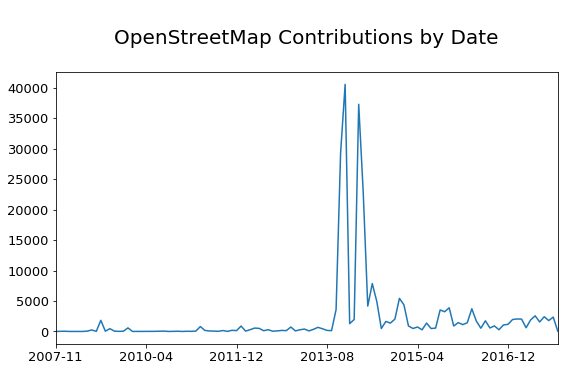

In [15]:
ax = df.plot(x='Date', y='Count', legend=False, figsize=(9,5), fontsize=13);
ax.set_title('\nOpenStreetMap Contributions by Date\n', fontsize= 20)
ax.set_xlabel('');

There are massive spikes in activity in November 2013, December 2013, and March 2014. 
Even after these spikes, activity is less consistent and usually higher than the number of posts before Ocotber 2013.

## Clean Tag Fields
Investigated key fields that were found to be clean:
* addr:district
* addr:door
* addr:interpolation
* addr:suburb
* addr:suite
* building:colour
* delivery
* maxspeed
* oneway
* roof:colour
* roof:shape

The values for these keys were found to belong to the list of acceptable values as defined by the OSM Wiki.

### Building Color

Done.


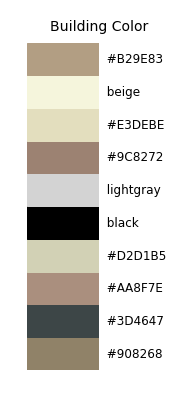

In [16]:
result = %sql SELECT value AS 'Building Color', COUNT(*) AS Count FROM tags WHERE key='building:colour' GROUP BY value ORDER BY Count DESC LIMIT 10;
df = result.DataFrame()
colors = df['Building Color'].tolist()

fig = plt.figure(figsize=[1, 5])
ax = fig.add_axes([0, 0, 1, 1])

for n, c in enumerate(colors):
    r1 = mpatch.Rectangle((0, n), 2, 1, color=c)
    txt = ax.text(2, n+.5, '  ' + c, va='center', fontsize=12)
    ax.add_patch(r1)

ax.text(2, n + 1.5, 'Building Color', ha='center', va='center', fontsize=14)
ax.set_xlim(0, 2)
ax.set_ylim(0, n + 2)
ax.axis('off');

### Roof Color

Done.


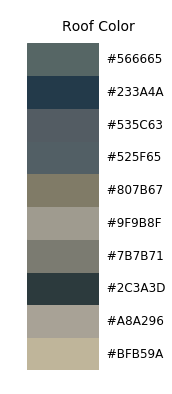

In [17]:
result = %sql SELECT value AS 'Roof Color', COUNT(*) AS Count FROM tags WHERE key='roof:colour' GROUP BY value ORDER BY Count DESC LIMIT 10;
df = result.DataFrame()
colors = df['Roof Color'].tolist()

fig = plt.figure(figsize=[1, 5])
ax = fig.add_axes([0, 0, 1, 1])

for n, c in enumerate(colors):
    r1 = mpatch.Rectangle((0, n), 2, 1, color=c)
    txt = ax.text(2, n+.5, '  ' + c, va='center', fontsize=12)
    ax.add_patch(r1)

ax.text(2, n + 1.5, 'Roof Color', ha='center', va='center', fontsize=14)
ax.set_xlim(0, 2)
ax.set_ylim(0, n + 2)
ax.axis('off');

Unsuprisingly, the most popular building colors are generally lighter and less grey-toned than the most popular roof colors.

### Delivery

In [18]:
%%sql
SELECT value AS 'Delivery', COUNT(*) AS Count 
FROM tags
WHERE key='delivery'
GROUP BY value
ORDER BY Count DESC

Done.


Delivery,Count
yes,48
no,37


As is shown in a query below in the Amenities section, there are 1012 restaurants, 390 cafes, and 277 fast food establishments in this area of the map.  Only a very small portion of these contain data about whether or not they offer delivery.

### Speed Limit

In [19]:
%%sql
SELECT value AS 'Speed Limit', COUNT(*) AS Count 
FROM tags
WHERE key='maxspeed'
GROUP BY value
ORDER BY Count DESC;

Done.


Speed Limit,Count
25 mph,1624
35 mph,113
20 mph,66
40 mph,41
30 mph,30
45 mph,25
5 mph,5


The vast majority of streets in this map have a speed limit of 25 mph.

### One Way Streets

In [20]:
%%sql
SELECT value AS 'One Way', COUNT(*) AS Count 
FROM tags
WHERE key='oneway'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


One Way,Count
yes,2193
no,204
reversible,7
-1,5


In [21]:
%%sql
-- Values of oneway for those that also have the 'highway' tag
SELECT value AS 'One Way', COUNT(*) AS Count 
FROM tags
WHERE key='oneway' and id in (SELECT DISTINCT id
                              FROM tags
                              WHERE key='highway')
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


One Way,Count
yes,2182
no,204
reversible,7
-1,5


The vast majority of the values for the 'oneway' tag refer to highways, and a vast majority of these are one way.

### Roof Shape

In [22]:
%%sql
SELECT value AS 'Roof Shape', COUNT(*) AS Count 
FROM tags
WHERE key='roof:shape'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Roof Shape,Count
flat,7703
skillion,207
pyramidal,192
gabled,187
round,48
hipped,47
dome,34
onion,4
mansard,3


## Problems Encountered in the Map Data: Simple Cleaning

Fields cleaned with a simple mapping of only values:
* addr:floor ({'2nd': '2'})
* building:levels
* building:material ({'40' : None})
* building:part (e.g. {'#7F7E79': None})
* height (e.g. {'20ft' : '6.1'}, since height should be in meters with no units)
* min_height ({'5;5.5' : '5'})
* nycdoitt:bin
* highway
* roof:material ({'concrete;grass' : 'grass'})

In [23]:
%%sql
SELECT value AS 'Building Material', COUNT(*) AS Count 
FROM tags
WHERE key='building:material'
GROUP BY value
ORDER BY Count DESC;

Done.


Building Material,Count
brick,3217
glass,823
metal,203
concrete,151
plaster,55
stone,47
copper,13
wood,6
granite,1


In [24]:
%%sql
SELECT value AS 'Roof Material', COUNT(*) AS Count 
FROM tags
WHERE key='roof:material'
GROUP BY value
ORDER BY Count DESC;

Done.


Roof Material,Count
concrete,7405
metal,90
copper,82
glass,82
roof_tiles,75
stainless_steel,64
brick,44
stone,14
grass,4
slate,3


In [25]:
%%sql
SELECT value AS 'Building Part', COUNT(*) AS Count 
FROM tags
WHERE key='building:part'
GROUP BY value
ORDER BY Count DESC;

Done.


Building Part,Count
yes,7675
apartments,10
office,1
steps,1


The building tag mostly serves to mark that the subject of the node represents a part of building (e.g. Times Square Ball is a part of the One Times Square building).

In [26]:
%%sql
SELECT value AS 'Highway', COUNT(*) AS Count 
FROM tags
WHERE key='highway'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Highway,Count
footway,2618
traffic_signals,1314
crossing,1086
residential,713
primary,555
secondary,555
service,390
steps,329
unclassified,327
bus_stop,207


In [27]:
%%sql
SELECT value AS 'Building Levels', COUNT(value) AS Count 
FROM tags
WHERE key='building:levels'
GROUP BY value
ORDER BY Count Desc
LIMIT 10;

Done.


Building Levels,Count
4,308
5,307
6,258
1,208
3,164
14,149
2,144
12,138
16,136
17,136


In [28]:
%%sql
SELECT MAX(CAST(value AS INT)) AS 'Maximum Levels'
FROM tags
WHERE key='building:levels'
LIMIT 10;

Done.


Maximum Levels
80


In [29]:
%%sql
SELECT MAX(CAST(value AS INT)) AS 'Maximum, Minimum Height'
FROM tags
WHERE key='min_height'
LIMIT 10;

Done.


"Maximum, Minimum Height"
330


In [30]:
%%sql
SELECT MAX(CAST(value AS INT)) AS 'Maximum Height'
FROM tags
WHERE key='height';

Done.


Maximum Height
541


In [31]:
%%sql
SELECT value
FROM tags
WHERE id = (SELECT id
              FROM tags
              WHERE key='height' AND
                  value=(SELECT MAX(CAST(value AS INT)) AS 'Maximum Height'
              FROM tags
              WHERE key='height'))

Done.


value
metal
yes
541
gray
124
pyramidal


The tallest building in this data set (and in all of New York) is One World Trade Center, with a height of 541 meters.  However as the query immediately above shows, the element that has the height tag does not also include a name tag key.

## Problems Encountered in the Map Data: More Complex Cleaning

Fields with known problems:
* zip code (addr:postcode, postal_code)
* address unit (addr:unit)
* housenumber (addr:housenumber)
* street (addr:street)
* city (addr:city)
* state (addr:state)
* country (addr:country)
* place (addr:place)
* full address (addr:full)
* levels and floors ('addr:floor', 'addr:level', 'building:level', 'building:levels')
* phone number (phone, contact:phone, phone:emergency, contact:fax, Phone, phone_1, fax)
* capacity
* building
* amenity
* shop
* leisure
* cuisine

### Zip Codes
Postcodes were represented inconsistently in the data for the 'addr:postcode'.  Some included a prefix of NY or were in the ZIP+4 format.  These zip codes were fixed programmatically using regular expressions.

I also manually assembled a list of valid zip codes for the areas included in the map.  Some postcodes in the data set were not present in the list.  For instance, 10023, which represents the Lincoln Square area of Manhattan, was erroneously assigned to an address near City Hall.  These zip codes were manually corrected with a dictionary mapping.  Typos in postcodes, such as ‘100014’ which has six digits, were also corrected manually.

Example errors in zip codes:
* 'NY 10007'
* '10002-1013'
* '100014'
* '10023'

The postcodes in the 'postal_code' were clean, but needed to have their key changed to 'addr:postcode'.

In [32]:
%%sql
SELECT value AS 'Zip Code', COUNT(*) AS Count 
FROM tags
WHERE key='addr:postcode'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Zip Code,Count
10011,2824
10003,2563
10014,2556
10002,2494
10013,2175
10016,1925
10009,1685
10001,1666
10012,1570
10010,971


### Address Unit
There were only a few values that were non-numeric and hence not valid values for the key of 'addr:unit'.  For these values, if value contained 'Suite' then the key was changed to 'addr:suite' and the number was extracted and assigned to the value (similar for those that contained floor).  For all other values, the number was extracted and emitted.  In all cases, regular expressions were used.

Example errors in 'addr:unit':
* 'Suite #1'
* '19th Floor'
* 'Suite 8500'
* '#37'

### Housenumber

There were a variety of different forms of acceptable values for 'addr:housenumber'.  These included housenumbers of the form:
* '15'
* '10 1/2'
* '19 1/4'
* '184 3/4'
* '23B'
* '58 Rear'
* '10-17'
* '409 Rear-A'
* '38 Front A'
* '170,176'

A list of regular expressions for these forms of housenumbers were compiled.  Before the housenumbers were compared to the regular expressions, 'REAR' was replaced with 'Rear', the space was removed from housenumbers that had a number and 'A' separated by a space, and some of the housenumbers were corrected via mapping.  If the housenumber doesn't match any of these, then the number is extracted by taking the first element of the split of the housenumber.

A few of the housenumbers also included other information besides the housenumber, including the suite, street, and floor.  Also, some of the values also included directions (e.g. East, West) that would need to be appended to the value of the 'addr:street'.  All of these were added to a dictionary of additional tags.  When shaping the data, if the additional tag had a direction, then the id for this node/way/relation was appended to a list.  If this node/way/relation had a direction and 'addr:street' tag, and the value for 'addr:street' did not already start with a direction, then it was appended to it.

In [33]:
%%sql
SELECT value AS 'Housenumber', COUNT(value) AS Count 
FROM tags
WHERE key='addr:housenumber'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Housenumber,Count
1,254
2,185
15,163
25,159
10,145
100,140
11,137
45,134
7,133
40,131


It makes sense that the most popular housenumbers are relatively low and are only numbers (i.e do not contain any extra letters, 'Rear', etc.).

### Street
Out of the fields I investigated, 'addr:street' had the most problems.  There were problems with, and including examples:
* abbreviations of street types (e.g. St., Ave)
* no street types (e.g. Old Fulton)
* abbreviations of directions (e.g. S., E)
* inconsistency in numbered streets (Second Avenue vs. 2nd Avenue)
* including housenumbers
* including suite numbers
* including city
* including state
* including floor
* including zip code
* inconsistent capitalization (Avenue Of The Americas vs. Avenue of the Americas)
* wrong or no contraction on ordinal numbers (12nd Street, 31 Street)
* unnecessary appostrophes (e.g. Saint Mark's Place)
* wrong or inconsistent spacing (Laguardia Place vs. La Guardia Place)
* not valid streets (e.g. Gramery Park, World Trade Center)


Example errors in addr:street:
* '109 East 42nd Street'
* '10th Ave #2E'
* '230th East 51st Street'
* '334 Furman St, Brooklyn'
* '400th West 20th St., Suite 2N'
* '54 W 39th St New York, NY'
* 'E. 4th Street'
* 'Highline'

First all streets were changed to title case apart from some exceptions that should remain completely capitalized, like 'FDR Drive', and those like 'of' and 'the' that should be lowercase when not appearing as the first word.  After fully auditing, some of the streets were found to be completely invalid, like 'Track' and 'Washington Square Village'.  Values of None were emitted for these streets, and so were effectively removed from the data.  At this point there was a collection of streets that could not be corrected programmatically, and so were updated using a dictionary mapping.  These included '85th West Street' being changed to 'West 85th Street' and '29th' to '29th Street'.

The rest of the cities, if they were not in the previously mentioned mapping, were corrected mostly using regular expressions.  If the city, like 'New York' or 'Brooklyn' was present, that was removed from the street and was returned as the value for 'addr:city' tag key.  Then, commas were removed from the data set.  Regular expressions and a mapping were used to replace abbreviated directions for North, South, East, and West with their longer counterpart.  If a floor, suite, zip code, or housenumber was present these were removed from the street and were assigned to the 'addr:floor', 'addr:suite', 'addr:postcode', or 'addr:housenumber' tag, respectively.  Regular expressions were used to find numbered streets that didn't use numbers to represent them (e.g. Fourth as opposed to 4th).  These were then replaced using a mapping to their numbered equivalent.  Finally, the street type (e.g. Street, Road, Place) was extracted using regular expressions, and it was replaced using a mapping if it was an abbreviation.

```python
def update_street(s):
    s = title_case(s, ['fdr', 'un'], ['of', 'the'])

    if s in invalid_streets:
        return None
    if s in full_street_mapping:
        s = full_street_mapping[s]    
    
    s = remove_city(s)
    s = remove_commas(s)
    
    # Fix directional abbreviations
    s = re.sub('[\s]*W[\.]*[\s]+', ' West ', s).strip()
    s = re.sub('[\s]*E[\.]*[\s]+', ' East ', s).strip()
    s = re.sub('[\s]*S[\.]*$', ' South', s).strip()
    
    s = remove_floor(s)
    s = remove_suite(s)
    s = remove_postcode(s)
    s = remove_housenumber(s)
    s = update_non_number(s)
    
    st_type = get_street_type(s)
    if st_type in street_type_mapping:
        s = re.sub(st_type, street_type_mapping[st_type], s)
    
    return s.strip()
```

'State St & Water St' was the only value for 'addr:street' that included more than one street.  This was the address for SeaGlass Carousel in The Battery.  Since both Google Maps and their official site list their address using both streets, I decided to update the value to 'State Street & Water Street' and change it's key to 'addr:full'.

In [34]:
%%sql
SELECT value AS 'Street', COUNT(*) AS Count 
FROM tags
WHERE key='addr:street'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Street,Count
Broadway,617
2nd Avenue,482
3rd Avenue,393
8th Avenue,343
1st Avenue,326
5th Avenue,296
6th Avenue,291
Grand Street,260
The Bowery,248
Canal Street,242


It is unsurprising that these are the streets that appear most frequently in the data set; besides that there are an abundance of landmarks on Broadway, it along with the Avenues are the longest streets in Manhattan (being much longer than their cross streets).

In [35]:
%%sql
-- Most popular streets with street type = 'Street'
SELECT value AS 'Street', COUNT(*) AS Count 
FROM tags
WHERE key='addr:street' and value LIKE '% Street'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Street,Count
Grand Street,260
Canal Street,242
West 22nd Street,242
East 14th Street,241
Greenwich Street,230
Bleecker Street,223
East 10th Street,222
West 20th Street,217
Hudson Street,211
West 11th Street,209


The top ten streets have very similar frequencies, most likely since these streets are all comparable in length.

In [36]:
%%sql
--Most popular streets in the Brooklyn part of map

SELECT value AS 'Street', COUNT(*) AS Count 
FROM tags
WHERE key='addr:street' and id in (SELECT id
                                   FROM tags
                                   WHERE key='addr:city' and value='Brooklyn')
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Street,Count
Henry Street,12
Willow Street,9
Water Street,6
Front Street,5
Columbia Heights,4
Clark Street,3
Hicks Street,3
Jay Street,3
Main Street,3
Old Fulton Street,3


### Cities

There was inconsistency with how cities were represented.  The only two acceptable cities are New York and Brooklyn.  The addr:city tags erroneously included the state, referred to the neighborhood as opposed to the city, and had capitalization inconsistencies.  All those referring to New York, Manhattan, and its neighborhoods were mapped to New York; there were no problems with those marked 'Brooklyn.'

Example errors in city:
* 'Manhattan NYC'
* 'NEW YORK CITY'
* 'New York City'
* 'New York, NY'
* 'Tribeca'
* 'York City'
* 'new york'

In [37]:
%%sql
SELECT value AS 'City', COUNT(*) AS Count 
FROM tags
WHERE key='addr:city'
GROUP BY value
ORDER BY Count DESC;

Done.


City,Count
New York,3317
Brooklyn,77


###  States
Almost all of the values for addr:state were 'NY' with only the errors being those listed below.

Errors in state:
* '10009'
* 'New York'
* 'New York State'
* 'ny'

Since 'NY' is the only valid value, a function was not required and all values for the key 'addr:state' were assigned to 'NY'.

### Countries
453 of the values for the key addr:country were 'US', with only five being 'USA'.  Since 'US' is the only valid value, a function was not required and all values for the key 'addr:country' were assigned to it.

### Place
addr:place should only be used in the cases where the address does not have any streets and only a housenumber and village, island, territorial zone, etc. can be used to refer to it.

I updated the key for 'Hudson Street' to 'addr:street'.

Soho Mews is the name an apartment building and is also the value for the 'name' key tag for both of the nodes that also have it as the value for 'addr:place'.  Hence, I outputted its value as None, effectively removing it from the data set, since it is not an appropriate value for 'addr:place'.

The last appearance of 'addr:place' has a value of 'Manhattan Island' and is in the tags for a node that contains a street address, so it is not valid.

### Full Address
There were three appearances of the 'addr:full' key in the data.  This tag key is only meant to be used when the address cannot be expressed using the structured address fields.

The first value: '20 Jay Street #842, Brooklyn, New York 11201' did not meet this criteria.  Furthermore, this node also included the structured address tags (e.g. 'addr:housenumber' = '20').  The only tag it was missing was for 'addr:suite', which I added to the addtl_tags dictionary, so that it may be assigned to this address' tags.

The next value, '42nd Street Between 7th Avenue and Broadway' is for the Times Square Ball.  This address did not include any of the structured address tags.  This full address value was also unnecessary, since it has a well defined address at the top of One Times Square, also known as 1475 Broadway.  So, I added the appropriate values for housenumber, street, city, state, and postcode to addtl_tags.

The last value was for Bryant Park at 'Between 40th and 42nd Streets at 6th Avenue'.  I changed this to '6th Avenue between 40th and 42nd Streets', so that it had the between streets at the end of the address.  This address also had all of the appropriate structured address tags that had information beyond this street address, such as city, zip code, and state.

### Levels and Floors

The values for 'addr:level' are clean, but their key needed to be changed to 'addr:floor'.


Similarly, the values for 'building:level' are clean, but their key needed to be changed to 'building:levels', which was explored above.


### Phone Numbers
According to the OSM Wiki, phones must be represented as a plus sign, country code, area code, local number all either separated by dashes or by spaces; I chose to use dashes.

Phone numbers were represented in a variety of ways, including with no spaces or dashes, no country code, with parentheses, using periods, extensions, or with multiple phone numbers.  Only the first phone number was emitted and no extensions were included in the updated numbers.

Example errors in phone numbers:
* '7188753700'
* '917 639 3089'
* '646) 205-7782'
* '2127547403#100,107,108,109'
* '212.229.2226'
* '1 (646) 598-0100'
* '001 646-6740001'
* '+12127777702'

Some phone numbers started correctly with the +1 country code for the United States, others only included the 1, others started with 001 (which is the exit code for most countries and how the +1 is dialed on phones that do not have the plus sign capability), and others did not include any part of the country code.

Values for the 'phone', 'contact:phone', 'phone:emergency', 'contact:fax', 'Phone', and 'phone_1' tags were updated using the code below.  In addition, the tag keys for 'Phone' and 'phone_1' were corrected to 'phone'.


```python
def is_valid_phone(phone):
    r = re.compile(r'^\+1-\d{3}-\d{3}-\d{4}$')
    if r.match(phone) is not None:        
        return True
    else:
        return False

# Use this to clean all phone number tag fields:
# contact:phone, Phone, phone_1, phone:emergency, fax, contact:fax
def update_phone(phone):
    """Returns the cleaned version of the phone number, and only returns
    the first phone number listed"""
    # replace multiple spaces with one space
    phone = re.sub('\s+', '', phone).strip()
    for ch in ['(',')','.','-']:
        phone = phone.replace(ch, '')
    
    if phone.startswith('001'):
        phone = '+' + phone[2:]
    if not phone.startswith('+'):
        phone = '+' + phone
    if phone[1] != '1':
        phone = phone[0] + '1' + phone[1:]
    
    phone = phone[0:2] + '-' + phone[2:5] + '-' + phone[5:8] + '-' + phone[8:]
    
    # Do not return second phone numbers or extensions
    phone = phone[0:15]
    
    if is_valid_phone(phone):
        return phone
    else:
        return None

```


In [38]:
%%sql
SELECT value AS 'Phone Number', COUNT(*) AS Count 
FROM tags
WHERE tags.key in ('phone', 'contact:phone', 'phone:emergency',
                   'contact:fax', 'fax')
GROUP BY value
ORDER BY Count DESC
LIMIT 5;

Done.


Phone Number,Count
+1-844-359-2523,4
+1-212-533-4575,3
+1-212-219-0666,2
+1-212-227-3400,2
+1-212-233-8338,2


None of the phone numbers occurred more than 4 times in the data set, and 913 out of 932 phone numbers only occurred once.

In [39]:
%%sql
CREATE VIEW phone_count_again AS
SELECT phone_counts.Count, COUNT(*) AS Frequency
FROM (SELECT COUNT(*) AS Count 
      FROM tags
      WHERE tags.key in ('phone', 'contact:phone', 'phone:emergency',
                   'contact:fax', 'Phone', 'phone_1', 'fax')
      GROUP BY value
      ORDER BY Count DESC) phone_counts
GROUP BY Count;

SELECT *
FROM phone_count_again;

(sqlite3.OperationalError) table phone_count_again already exists [SQL: "CREATE VIEW phone_count_again AS\nSELECT phone_counts.Count, COUNT(*) AS Frequency\nFROM (SELECT COUNT(*) AS Count \n      FROM tags\n      WHERE tags.key in ('phone', 'contact:phone', 'phone:emergency',\n                   'contact:fax', 'Phone', 'phone_1', 'fax')\n      GROUP BY value\n      ORDER BY Count DESC) phone_counts\nGROUP BY Count;"]


In [40]:
%%sql
SELECT pc1.Count, 100*pc1.Frequency/(SELECT SUM(Frequency) FROM phone_count_again) 'Percent of Total'
FROM phone_count_again pc1, phone_count_again pc2
WHERE pc1.Count = pc2.Count
GROUP BY pc1.Count;

Done.


Count,Percent of Total
1,97
2,1
3,0
4,0


### Capacity
Capacity only had two non-numeric values.  One was had a value of '56 seats' which was mapped to '56', the other erroneously had opening hours, so its key was changed to 'opening_hours'.

In [41]:
%%sql
SELECT value AS 'Capacity', COUNT(*) AS Count 
FROM tags
WHERE key='capacity'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Capacity,Count
2,1244
5,303
4,165
10,60
7,46
39,36
15,29
31,24
6,23
27,21


In [42]:
%%sql
SELECT MAX(CAST(value AS INT)) AS Maximum
FROM tags
WHERE key='capacity'
LIMIT 10;

Done.


Maximum
100


### Buildings
The values for the tag key 'building' were compared to the list of valid values assembled using BeautifulSoup from the OSM Wiki.  The value of 'publib' was a simple typo and was mapped to 'public'.  Some of the values were not valid and could not be mapped to logical alternatives; these were: 'no', 'tower', and 'works'.  The other values needed to have their key changed, as they were incorrectly labeled as buildings, and possibly their value changed as well.  For instance, 'college' and 'courthouse' should have been assigned to the key 'amenity', as should have 'convent', but its value needed to be adjusted to 'monastery'.

There was also one tag with the key 'building_1' which I reassigned to 'building'.

In [43]:
%%sql
SELECT value AS 'Building', COUNT(*) AS Count 
FROM tags
WHERE key='building'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Building,Count
yes,18687
apartments,421
commercial,73
church,67
school,44
hotel,31
office,30
residential,19
roof,19
construction,14


The vast majority of building tags were only labeled with a 'yes' value to note that a node marks a building.

### Amenities
The values for the tag key 'amenity' were cleaned in a similar fashion to those for 'building'.  Only one value only required a mapping of its value ('training' to 'school').  All others required a mapping of their key and/or value.  For instance, 'gym' needed to be changed to 'fitness_centre', but should have been assigned to the key 'leisure'.

There were also two tags with the key 'amenity_1' and one tag with the key 'amenity_2' which I reassigned to 'amenity'.

In [44]:
%%sql
SELECT value AS 'Amenity', COUNT(*) AS Count 
FROM tags
WHERE key='amenity'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Amenity,Count
bicycle_parking,1961
restaurant,1012
cafe,390
fast_food,277
bicycle_rental,231
bar,192
parking,181
bank,155
embassy,147
bench,140


### Shop
The values for the tag key 'shop' were cleaned in a similar fashion to those for 'building' and 'amenity'.  Four values required a mapping of their key (e.g. 'car_rental' should have been an 'amenity'), and the rest of those needed to have their value updated (e.g. 'beer' to 'alcohol' and 'mattress' to 'bed'.  One of the values of 'comics', needed to be changed to a value of 'books', but also be given an additional tag with key 'books' and value 'comics'.

There was also one tag with the key 'shop_1' which I reassigned to 'shop'.

In [45]:
%%sql
SELECT value AS 'Shop', COUNT(*) AS Count 
FROM tags
WHERE key='shop'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Shop,Count
clothes,214
convenience,86
supermarket,73
bakery,47
shoes,45
hairdresser,39
alcohol,37
books,34
deli,32
dry_cleaning,32


### Leisure
The values for the tag key 'leisure' were compared to the list of valid values assembled using BeautifulSoup from the OSM Wiki.  The only error was with the value of 'recreation_ground' which should have been assigned to the key 'landuse'.

In [46]:
%%sql
SELECT value AS 'Leisure', COUNT(*) AS Count 
FROM tags
WHERE key='leisure'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Leisure,Count
park,232
pitch,136
playground,73
garden,60
sports_centre,28
swimming_pool,14
fitness_centre,13
dog_park,11
common,6
track,6


### Cuisine

There was a lot of inconsistencies in how values for the key 'cuisine' were represented.  Some values erroneously included spaces (e.g. 'wine bar', while others were written as though they would have had spaces, but with the spaces replaced with underscores (e.g. 'american,_grilled_cheese,_tater_tots').

A list of the official cuisines was assembled from the OSM Wiki using BeautifulSoup.  User defined values are also accepted, so I added some of the values from the map that I thought were also acceptable.

First a couple of the values that had to be fully mapped before being split were mapped to corrected values.  Then values were split by any spaces or non-underscore punctuation, since there were many values that had many different cuisines separated by commas, slashes, and semicolons. Then leading underscores were removed, and the values were converted to lowercase and corrected via the mapping. 

For all other fields that required keys to be ressigned, I mapped the value to its new key.  However, cuisines had many array values(e.g. 'asian;vietnamese;sandwich') and many that were assigned incorrectly to the 'cuisine' key.  Therefore, unlike for other fields, a list of dictionaries was returned with each containing both the updated key and value from the update function.  Additionally, instead of keeping the values in an array format, the values were split and multiple key value pairs were emitted.

For example, 'indian;vegetarian' would be updated to:
[{'cuisine': 'indian'},
{'diet': 'vegetarian'}]

There was also one tag with the key 'cuisine_1' which I reassigned to 'cuisine'.

In [47]:
%%sql
SELECT value AS 'Cuisine', COUNT(*) AS Count 
FROM tags
WHERE key='cuisine'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Cuisine,Count
coffee_shop,97
pizza,91
italian,82
american,65
mexican,61
burger,53
japanese,44
chinese,41
sandwich,39
indian,36


The types of cuisine that appear the most often in the data set are regional/ethnic cuisines.

In [48]:
%%sql
-- The most popular cuisines among restaurants
SELECT value AS 'Cuisine', COUNT(*) AS Count 
FROM tags
WHERE key='cuisine' and id in (SELECT id
                               FROM tags
                               WHERE key='amenity' and value='restaurant')
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Cuisine,Count
italian,72
american,60
pizza,49
mexican,44
chinese,38
japanese,37
indian,31
thai,22
asian,19
burger,19


In [49]:
%%sql
-- The most popular cuisines among fast food restaurants
SELECT value AS 'Cuisine', COUNT(*) AS Count 
FROM tags
WHERE key='cuisine' and id in (SELECT id
                               FROM tags
                               WHERE key='amenity' and value='fast_food')
GROUP BY value
ORDER BY Count DESC
LIMIT 10;

Done.


Cuisine,Count
pizza,39
burger,29
sandwich,23
mexican,15
asian,5
chicken,5
indian,5
american,4
crepe,4
mediterranean,4


## Additional Suggestions for Improving the Data



This small section of map originally included 655 distinct tag keys with 201 having only one appearance in the data.  Many of these are acceptable, however there are also many that are either deprecated, no longer in use, or rejected.  For instance, while 'cuisine' is a widely used tag, 'cuisine_1' is not an appropriate tag key and was mapped to 'cuisine'.  Some unacceptable tag keys include: 'beer', 'bottle', 'male', 'species', 'whisky', 'noname', 'diaper', and 'cocktails'.

A first suggestion for cleaning these tags would be to use regular expressions to remove additional numbers (with or without a preceding underscore) appended to the end so that they may be the same as their acceptable counterparts.  As the query below shows, in this data set 'ISO3166-2' is the only key that should not have it's last number removed.  There are no disadvantages to performing this cleaning.

The wiki has a [page](https://wiki.openstreetmap.org/wiki/Map_Features) that lists the accepted tag keys.  One could use BeautifulSoup to get a list of the acceptable tags and compare the tag keys to these values.  However, there are accepted tags that are not on this list like for instance, '[destination](https://wiki.openstreetmap.org/wiki/Key:destination)' and '[horse](https://wiki.openstreetmap.org/wiki/Key:horse)' which have their own pages on the wiki.  Therefore, cleaning the tag keys according to this list may remove valid values from the data.   Proposed keys have their own pages, and they can be marked as accepted, abandoned (as in this page for '[habitat](https://wiki.openstreetmap.org/wiki/Proposed_features/Key:habitat)'), etc.  Consequently, if one was to check for the existence of a wiki page for the tag key, the many invalid keys that have pages, but were marked as invalid would still be included in the dataset.

In [50]:
%%sql
SELECT DISTINCT key AS Key
FROM tags
WHERE key LIKE '%1' OR key LIKE '%2' OR key LIKE '%3';

Done.


Key
is_in:iso_3166_2
healthcare:speciality_1
name_1
tourism_1
tiger:name_base_1
tiger:name_direction_prefix_1
tiger:name_type_1
tiger:zip_left_1
name_2
tiger:name_base_2
